This project is to predict the PM2.5 of Beijing. 

This [hourly data set](https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data) contains the PM2.5 data of US Embassy in Beijing.

## 1 Data preparation

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from numpy import concatenate
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.python.keras.layers import Dense, LSTM , Dropout
from tensorflow.python.keras import Sequential
from math import sqrt;

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Python/PM2-5/PRSA_data_2010.1.1-2014.12.31.csv')

# No: row number
# year: year of data in this row
# month: month of data in this row
# day: day of data in this row
# hour: hour of data in this row
# pm2.5: PM2.5 concentration (ug/m^3)
# DEWP: Dew Point (â„ƒ)
# TEMP: Temperature (â„ƒ)
# PRES: Pressure (hPa)
# cbwd: Combined wind direction
# Iws: Cumulated wind speed (m/s)
# Is: Cumulated hours of snow
# Ir: Cumulated hours of rain

In [ ]:
df.isnull().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [ ]:
df1 = df.dropna()

In [ ]:
df1['Date'] = pd.to_datetime(df1[['year','month','day','hour']])
df2 = df1.drop(columns = ['No','year','month','day','hour'])
# df2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# df2.describe()

In [ ]:
df2.set_index('Date',inplace=True)
df2.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
Date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


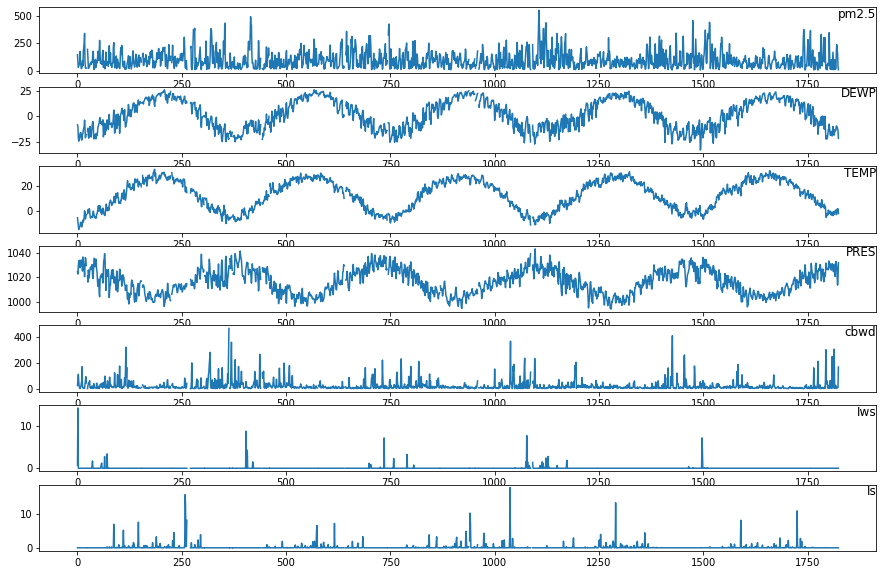

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# specify columns to plot
cols = [0, 1,2,3, 4, 5, 6]
i = 1  
groups = cols
# 统计以天进行重采样的平均值
values = df2.resample('D').mean().values  # pls note: the categorical feature is ignored automatically.
# plotting each column
plt.figure(figsize=(15,10))

for group in groups:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, group])
	plt.title(df2.columns[group], y=0.75, loc='right')
	i += 1

plt.show()

# if the index is not 'date' format:
# specify columns to plot
# groups = [0, 1, 2, 3, 5, 6, 7]
# i = 1
# # plotting each column
# pyplot.figure()

# for group in groups:
# 	pyplot.subplot(len(groups), 1, i)
# 	pyplot.plot(values[:, group])
# 	pyplot.title(dataset.columns[group], y=0.5, loc='right')
# 	i += 1
# pyplot.show()


In [ ]:
# # 对 pm2.5 数据按天进行聚合，并比较均值
# df2['pm2.5'].resample('M').mean().plot(title='pm2.5 resampled over day for mean', color='red') 
# plt.tight_layout()
# plt.show()

## 2 Lable Encoding
The Wind direction doesn’t contain numerical values so label encoding is done.



In [ ]:
# integer encode direction
encoder = LabelEncoder()
values = df2.values
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
values.shape

(41757, 8)

## 3 Check correlation - Data Visualization

In [ ]:
# # 查看 'TEMP' 和 'pm2.5' 特征之间的关系
# data_returns = df2.pct_change()
# sns.jointplot(x='TEMP', y='DEWP', data=data_returns)  
# plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


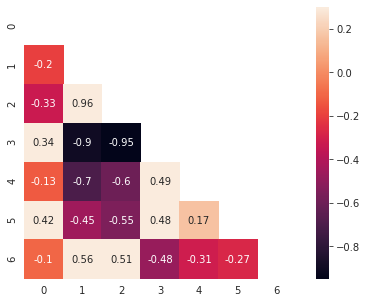

In [ ]:
import seaborn as sns

corr = np.corrcoef(values.T)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask,annot=True, vmax=.3, square=True)

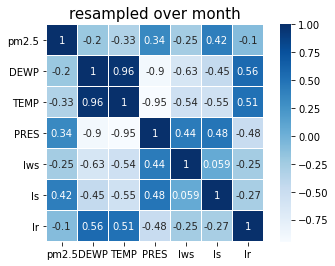

In [ ]:
# 对各特征按月进行聚合
mask = np.triu(np.ones_like(corr, dtype=np.bool))

plt.title('resampled over month',size=15)
sns.heatmap(df2.resample('M').mean().corr(),linewidths=0.1,vmax=1.0, 
            square=True, 
            # cmap=plt.cm.RdBu,
            cmap='Blues',             
            # mask=mask,
            linecolor='white', annot=True)

In [ ]:
df3 = df2.drop(columns = ['DEWP','PRES','cbwd'])
df3.head()

,pm2.5,TEMP,Iws,Is,Ir
Date,,,,,
2010-01-02 00:00:00,129.0,-4.0,1.79,0,0
2010-01-02 01:00:00,148.0,-4.0,2.68,0,0
2010-01-02 02:00:00,159.0,-5.0,3.57,0,0
2010-01-02 03:00:00,181.0,-5.0,5.36,1,0
2010-01-02 04:00:00,138.0,-5.0,6.25,2,0


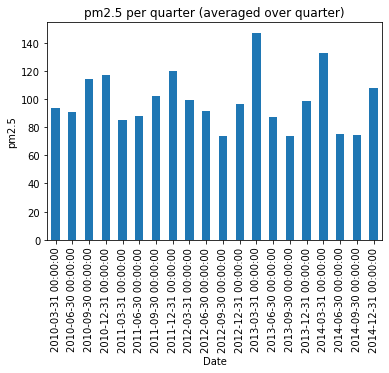

In [ ]:
import matplotlib.dates as mdates

# 对 'Global_active_power' 按季度进行聚合
df3['pm2.5'].resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=90)
plt.ylabel('pm2.5')
plt.title('pm2.5 per quarter (averaged over quarter)')
# ax=plt.gca()
df3.index = pd.to_datetime(df3.index,format='%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) #'%Y-%m-%d %H:%M:%S'
plt.show()

## 4 Converting to time Series Data
Since we use the LSTM neural network, we must sort the data according to the time. The dataset is transformed into a supervised learning problem. The weather variables for the hour to be predicted (t) are then removed. So, we have features for previous timestep (t-1) and for prediction of pollution PM2.5 taking its current timestep (t) data.



In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]     # there are 7(here data.shape[1]=7) variables recorded at each time.
	dff = pd.DataFrame(data)   #2075259 rows × 7 columns, while the col names are [0,1,2,3,4,5,6]. Column 0 is the target we want to predict.
	cols, names = list(), list()   
	# 输入序列(t-n, ... t-1)
	for i in range(n_in, 0, -1): 
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# 预测序列 (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# 组合起来
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# 丢掉NaN
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## 5 Normalize features

In [ ]:
# 把所有特征进行规范化
from sklearn.preprocessing import MinMaxScaler
# # 将数据按小时聚合
# df3_resample = df3.resample('h').mean()  # df3.shape: (41757, 6); after resampling using 'h', df3.resample.shape: (43800, 5)
values = df3.values 
# 特征归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# 转化为监督问题
reframed = series_to_supervised(scaled, 1, 1)
# 删除不需要的特征
reframed.drop(reframed.columns[-4:], axis=1, inplace=True)  # delete the non-target, the var1 is the target(pm2.5).
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
1   0.129779   0.245902   0.002372   0.000000        0.0  0.148893
2   0.148893   0.245902   0.003947   0.000000        0.0  0.159960
3   0.159960   0.229508   0.005522   0.000000        0.0  0.182093
4   0.182093   0.229508   0.008690   0.037037        0.0  0.138833
5   0.138833   0.229508   0.010265   0.074074        0.0  0.109658


In [ ]:
# Split to train & test
# We will only fit the model on the first 2 years(365 24 2 hours) of data, 
# then evaluate it on the remaining 3 years of data.
values = reframed.values
n_train_time = 365*24*2
train = values[:n_train_time, :]   # return the first n rows with all columns
test = values[n_train_time:, :]
train_X, train_y = train[:, :-1], train[:, -1]   # all the features except the last column
test_X, test_y = test[:, :-1], test[:, -1]
# 把数据转换为3维, reshape input to 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(17520, 1, 5) (17520,) (24236, 1, 5) (24236,)


## 6 Create models

Train on 17520 samples, validate on 24236 samples
Epoch 1/20
 - 2s - loss: 0.0050 - val_loss: 0.0019
Epoch 2/20
 - 2s - loss: 0.0012 - val_loss: 5.3024e-04
Epoch 3/20
 - 2s - loss: 8.3369e-04 - val_loss: 5.2284e-04
Epoch 4/20
 - 2s - loss: 8.1783e-04 - val_loss: 5.2340e-04
Epoch 5/20
 - 2s - loss: 8.0673e-04 - val_loss: 5.2494e-04
Epoch 6/20
 - 2s - loss: 8.1010e-04 - val_loss: 5.1966e-04
Epoch 7/20
 - 2s - loss: 7.9134e-04 - val_loss: 5.1862e-04
Epoch 8/20
 - 2s - loss: 7.9564e-04 - val_loss: 5.1747e-04
Epoch 9/20
 - 2s - loss: 7.8189e-04 - val_loss: 5.1720e-04
Epoch 10/20
 - 2s - loss: 7.8978e-04 - val_loss: 5.2213e-04
Epoch 11/20
 - 2s - loss: 7.7262e-04 - val_loss: 5.1656e-04
Epoch 12/20
 - 2s - loss: 7.7096e-04 - val_loss: 5.1641e-04
Epoch 13/20
 - 2s - loss: 7.7745e-04 - val_loss: 5.2466e-04
Epoch 14/20
 - 2s - loss: 7.5767e-04 - val_loss: 5.1757e-04
Epoch 15/20
 - 2s - loss: 7.6273e-04 - val_loss: 5.1901e-04
Epoch 16/20
 - 2s - loss: 7.5923e-04 - val_loss: 5.2699e-04
Epoch 17/20

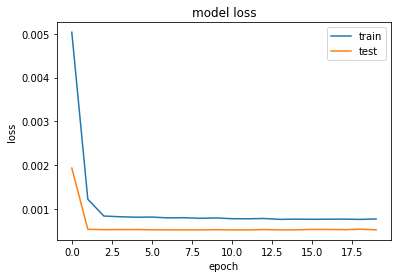

In [ ]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential


# 搭建网络模型
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# 训练网络
history = model.fit(train_X, train_y, 
                    epochs=20, batch_size=72, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)
# 统计 loss 值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# Make predictions
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [ ]:
# from sklearn.metrics import mean_squared_error

# invert scaling for forecast 对预测值进行反演缩放
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)   # 数据格式要和原来归一化之前的shape必须一样；如果不一样可以用concatenate合并数据
inv_yhat = scaler.inverse_transform(inv_yhat)    #scaler.inverse_transform(X_scaled) 是将 标准化后的数据 转换为 原始数据
inv_yhat = inv_yhat[:,0]

# invert scaling for actual 对真实值进行反演缩放
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE and MAE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
mae = (mean_absolute_error(inv_y, inv_yhat))
print('Test MAE: %.3f' % mae)

Test RMSE: 22.662
Test MAE: 12.562


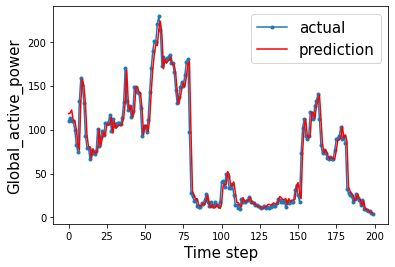

In [ ]:
# Plotting the Graph of Actual vs Predicted
# print('Actual :', inv_y)
# print('Predicted:', inv_yhat)
# # plot history
# pyplot.plot(inv_y, label='Actual')
# pyplot.plot(inv_yhat, label='Predicted')
# pyplot.legend()
# pyplot.show()

# compare 200h 真实值和预测值 
aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

Notes: 

https://zhuanlan.zhihu.com/p/28746221

https://www.kaggle.com/aishwaryamaurya/air-pollution-forecaste